In [1]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

<div class="alert alert-danger"><b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>


<a id="SIMUSTO"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> III. Eléments de simulation stochastique et méthode du rejet</h1>


<div class="alert alert-success"> On présente ici des éléments de simulation stochastique. On discute d'abord de méthodes pour vérifier qu'une variable aléatoire suit une loi donnée, puis on présente la méthode du rejet, qui permet de générer une variable aléatoire avec une loi donnée. Une autre méthode classique et très importante est la méthode d'inversion de la fonction de répartition qui fait l'objet du DM.<br>
<br>
Nous verrons dans la suite du cours que la méthode du rejet est à la base de la technique d'échantillonnage préférentiel et des méthodes de Monte-Carlo à base de chaînes de Markov.<br>
<br>
<b>Rappel</b>. La fonction de répartition d'une variable aléatoire $X$, notée $F_X$, est la fonction $F_X(x) = P(X \leq x)$.
</div>



<h2> III.1. Histogramme et densité </h2>

Soit $X$ une variable aléatoire absolument continue que l'on sait générer mais dont on ne connaît pas la densité. Pour vérifier qu'une densité candidate $g$ est proche de la véritable densité, une manière très visuelle est de générer un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ et de comparer un histogramme associé à cet échantillon à $g$.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.1.<b> Soit $(Y_k)$ i.i.d. qui suivent une loi exponentielle de paramètre $1/2$. Le théorème central limite prédit que
$$ X = \sum_{k=1}^{100} Y_k $$
suit approximativement une loi normale : quels sont les paramètres de cette loi ?</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.1.<b> Moyenne = $n/\lambda$ et Var = $n/\lambda^2$ </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.2.</b> Vérifiez votre réponse en complétant le script suivant, et commentez les résultats obtenus.</p>

100000


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


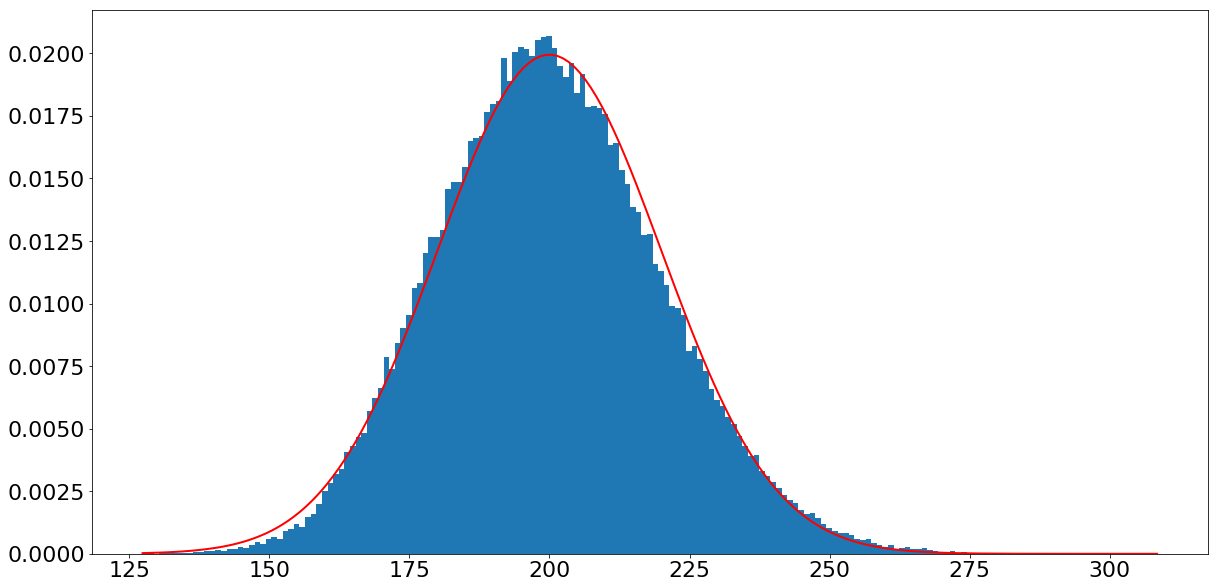

In [2]:
taille_echantillon = 10**5
nb_termes = 100
parametre_exp = .5
echantillon = sum(np.random.exponential(scale = 1/parametre_exp, size = (nb_termes, taille_echantillon)))
print(len(echantillon)) 
count, bins, ignored = plt.hist(echantillon, np.arange(np.min(echantillon)-0.5, np.max(echantillon)+1.5), normed=True)
mu = nb_termes/parametre_exp
sigma = np.sqrt(nb_termes/(parametre_exp**2))
plt.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.2.</b> L'histogramme s'approche de la loi théorique de distribuition gaussienne.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.3.</b> Discutez des limitations potentielles de cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.3.</b> Le choix de la taille de chaque block du histogramme joue un role fondamental dans la comprehension de la loi théorique. Un taille très petit peux se fait tromper le analyste dans le choix de la loi théorique.</div>

<h2> III.2. Fonction de répartition empirique </h2>

Nous présentons maintenant une méthode plus rigoureuse. On considère un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ à valeurs dans $\mathbb{R}$ et on s'intéresse à la fonction
$$ \widehat F_N: x \in \mathbb{R} \mapsto \frac{1}{N} \sum_{k=1}^N {\bf 1}(X_k \leq x). $$


<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.1.</b> Montrez que $\widehat F_N(x) \to F_X(x)$ pour tout $x \in \mathbb{R}$ fixé.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.1.</b> </div>

La fonction $\widehat F_N$ es appelée **fonction de répartition empirique** de $X$. Pour vérifier qu'une variable aléatoire suit une loi de fonction de répartition $F$, on peut donc superposer $\widehat F_N$ et $F$ et accepter que $F = F_X$ si les deux courbes sont proches pour $n$ suffisamment grand.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.2.</b> Complétez le script suivant pour vérifier que les fonctions <code>stats.uniform.rvs</code>, <code>stats.expon.rvs</code>, <code>stats.poisson.rvs</code> et <code>stats.gamma.rvs</code> renvoient bien des variables aléatoires qui suivent la loi uniforme, la loi exponentielle, la loi de Poisson et la loi gamma, respectivement. Utilisez pour cela la fonction <code>ecdf</code>. A partir de quelle taille d'échantillon les approximations vous semblent-elles valides ?</p>

In [3]:
def ecdf(echantillon):
    """
    Cette fonction prend en entrée un échantillon
    et renvoie le couple (sorted_, yvals) qui est tel que
    np.step(sorted_, yvals) trace la fonction de répartition empirique
    """
    sorted_ = np.sort(echantillon)
    yvals = np.arange(len(sorted_))/float(len(sorted_))
    sorted_ = np.append(sorted_, np.amax(echantillon))
    sorted_ = np.append(sorted_, np.amax(echantillon)+1)
    sorted_ = np.insert(sorted_, 0, np.amin(echantillon)-1)
    yvals = np.append(yvals, 1)
    yvals = np.append(yvals, 1)
    yvals = np.insert(yvals, 0, 0)
    return (sorted_, yvals)

100
74


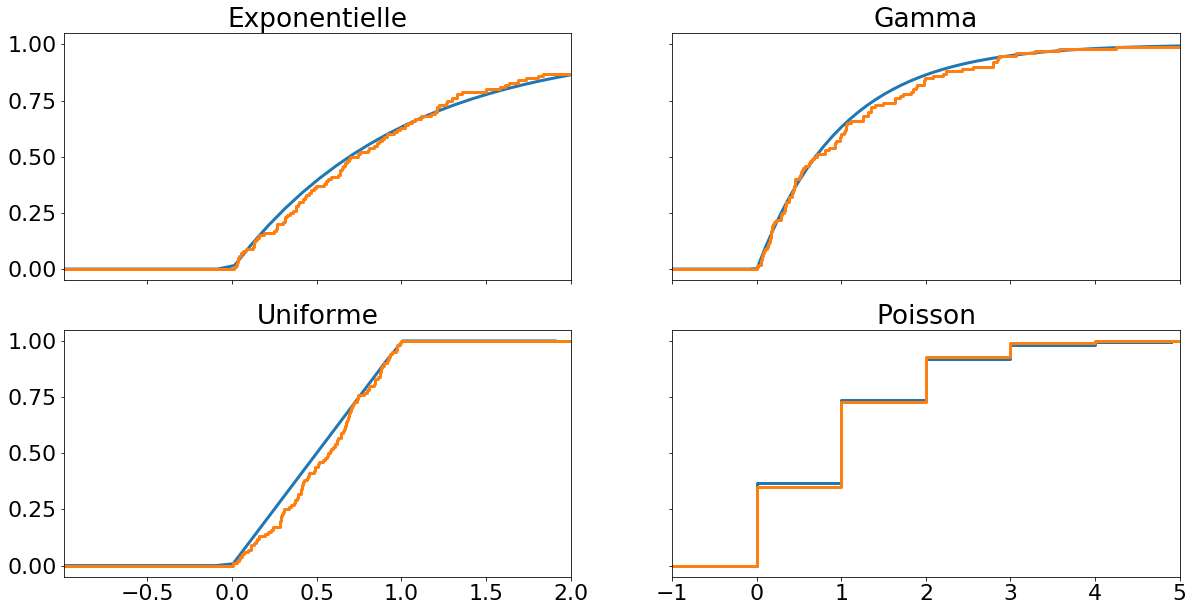

In [4]:
taille = 10**2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0: # exponentielle
        echantillon = stats.expon.rvs(size = taille ) # experimentais
        print(np.size(echantillon))
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        print(np.size(x))
        a = ax1
        a.plot(x, stats.expon.cdf(x)) 
    if i==1: # gamma
        echantillon = stats.gamma.rvs(1,size = (taille))
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, 1))
    if i==2: # uniforme
        echantillon = stats.uniform.rvs(size = (taille))
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x))
    if i==3: # poisson
        echantillon = stats.poisson.rvs(1,size = (taille))
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x,1))
    s, y = ecdf(echantillon)
    a.step(s, y)
    a.set_title(t[i])
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.2.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.3.</b> Soient $U_1$, $U_2$ indépendantes et uniformément réparties sur $[0,1]$ et $Z = \sqrt{- 2 \ln U_1} \cos(2 \pi U_2)$. Vous pouvez générer au plus 200 variables aléatoires. Parmi les choix suivants, quelle est selon vous la loi de $Z$?
<br>

&#9679; Cauchy, i.e., $f_Z(z) \propto 1/(1+z^2)$ (cf. ``stats.cauchy``)

<br>

&#9679; Laplace, i.e., $f_Z(z) \propto e^{-\lvert z \rvert}$ (cf. ``stats.laplace``)

<br>

&#9679; Gauss, i.e., $f_Z(z) \propto e^{-z^2/2}$ (cf. ``stats.norm``)</p>

Text(0.5,0.98,'Choix de la Loi Théorique')

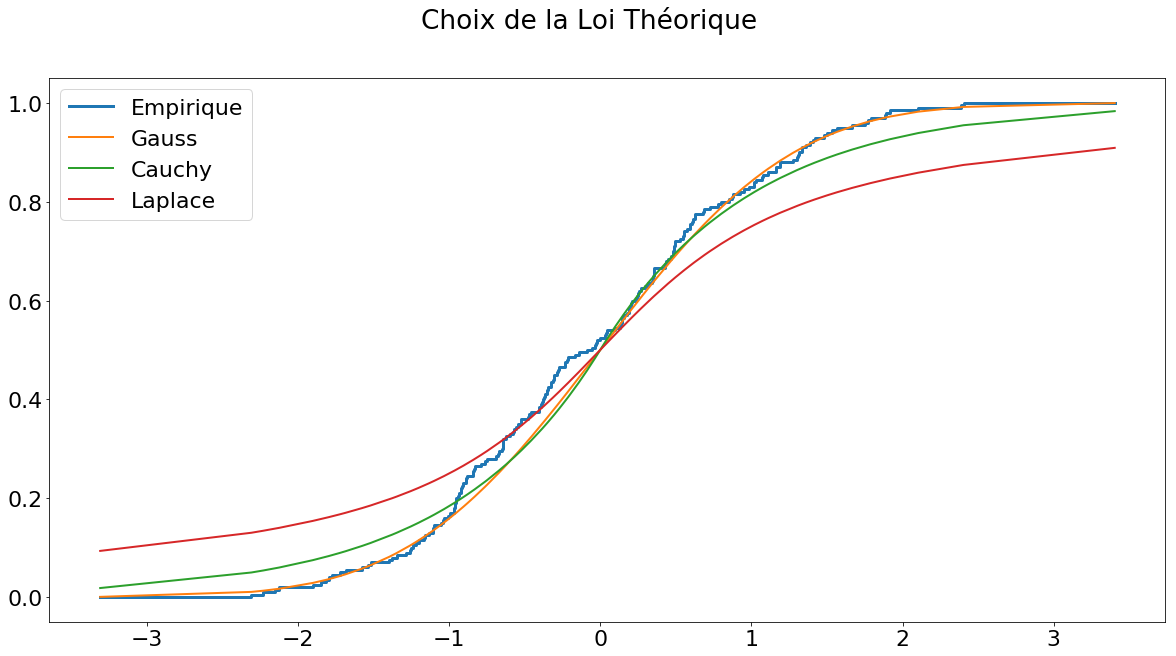

In [5]:
taille_echantillon = 200
u = stats.uniform.rvs(size = (2,taille_echantillon))
z = np.sqrt(-2*np.log(u[0,:]))*np.cos(2*np.pi*u[1,:])
s,y = ecdf(z)
plt.step(s,y, label="Empirique")
plt.plot(s, stats.norm.cdf(s), linewidth=2, label="Gauss")
plt.plot(s, stats.laplace.cdf(s), linewidth=2, label="Cauchy")
plt.plot(s, stats.cauchy.cdf(s), linewidth=2, label="Laplace")
plt.legend()
plt.suptitle("Choix de la Loi Théorique")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.3.</b> Methode plus globale aui ne depend pas de parametre : convergence uniforme.</div>

Jusqu'à présent, la méthode proposée n'est pas beaucoup plus rigoureuse que l'utilisation des histogrammes, à la différence qu'il n'y a pas besoin de faire de choix pour les urnes. Un autre avantage est que la vitesse de convergence $\widehat F_N \to F_X$ peut être quantifiée comme on le voit maintenant.

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.4. $\star$</b> Quel résultat contrôle les fluctuations de $\widehat F_N(x)$ autour de $F_X(x)$? Montrez que
$$ P \left( \widehat F_N(x) - \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95 \ \text{ où } \ \varepsilon_N(x) = \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} $$
avec $\sigma(x)^2 = F_X(x) (1-F_X(x))$, $F$ la fonction de répartition de la loi normale centrée réduite et $F^{-1}$ son inverse.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.4.</b> </div>

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.5. $\star$</b> Quel est le problème de la fonction $\varepsilon_N$? Proposez une fonction $\widehat \varepsilon_N$ sans ce problème et qui satisfait aussi
$$ P \left( \widehat F_N(x) - \widehat \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \widehat \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95. $$</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.5.</b> </div>

On remarquera en particulier que $[\widehat F_N(x) - \widehat \varepsilon_N(x), \widehat F_N(x) + \widehat \varepsilon_N(x)]$ est un **intervalle de confiance bilatéral symétrique** de $F_X(x)$ au niveau asymptotique $95\%$.

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.6. $\star$</b> Reprenez et complétez le script précédent pour ajouter les deux enveloppes $\widehat F_{100} \pm \widehat \varepsilon_{100}$. Utilisez pour cela les fonctions <code>np.std</code> et <code>stats.norm.ppf</code>.</p>

In [104]:
taille = 10**3
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0:
        echantillon = stats.expon.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax1
        a.plot(x, stats.expon.cdf(x, loc=0, scale=1))
    if i==1:
        echantillon = stats.gamma.rvs(a=2, loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, a=2, loc=0, scale=1))
    if i==2:
        echantillon = stats.uniform.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x, loc=0, scale=1))
    if i==3:
        echantillon = stats.poisson.rvs(mu=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x, mu=1))
    s, y = ecdf(echantillon)
    a.step(s, y)
    a.set_title(t[i])
    epsilon = # TO DO
    a.step(s,y + epsilon, 'g', linewidth=1.0)
    a.step(s,y - epsilon, 'g', linewidth=1.0)
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])
    

SyntaxError: invalid syntax (<ipython-input-104-d679c1809660>, line 29)

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.6.</b> </div>

<h2> III.3. Méthode du rejet </h2>

Soit $Y$ une variable aléatoire absolument continue admettant pour densité $f$ satisfaisant $f(x) = 0$ si $\lvert x \rvert \geq 1$ et $\sup f < \infty$. On génère itérativement des points uniformément répartis sur $[-1,1] \times [0,K]$ avec $K \geq 2\sup f$ jusqu'à avoir généré un point sous la courbe $f$. Sur la figure ci-dessous, on a généré les quatre croix avant de générer le point noir.

![title](rejet.png)



On considère alors l'abscisse du premier point sous la courbe, que l'on note $Z$. Dans le deuxième devoir maison, vous montrerez que
$$ \tag{1} P(Z \leq z) = P(X \leq z \mid U \leq f(X)), \ z \in \mathbb{R}, $$
avec $(X, U)$ uniformément réparti sur $[-1,1] \times [0,K]$.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.1.</b> Donnez la densité de $(X, U)$ et déduisez de (1) que $Z$ admet $f$ pour densité.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.1.</b> </div>


<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.2.</b> Quelle est la loi du nombre de points rejetés avant d'en accepter un? Précisez la valeur du paramètre de cette loi. En déduire le nombre moyen de simulations nécessaires afin de simuler $Y$ selon cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.2.</b> Loi Geometrique.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.3.</b> Ecrivez un script qui implante cette méthode dans le cas où $f$ est la densité normale tronquée, i.e.,
$$ f(x) \propto \exp\left( -\frac{x^2}{2} \right) {\bf 1}(-1 \leq x \leq 1). $$
Vous vérifierez bien que la sortie de votre script admet la bonne loi.</p>

25054


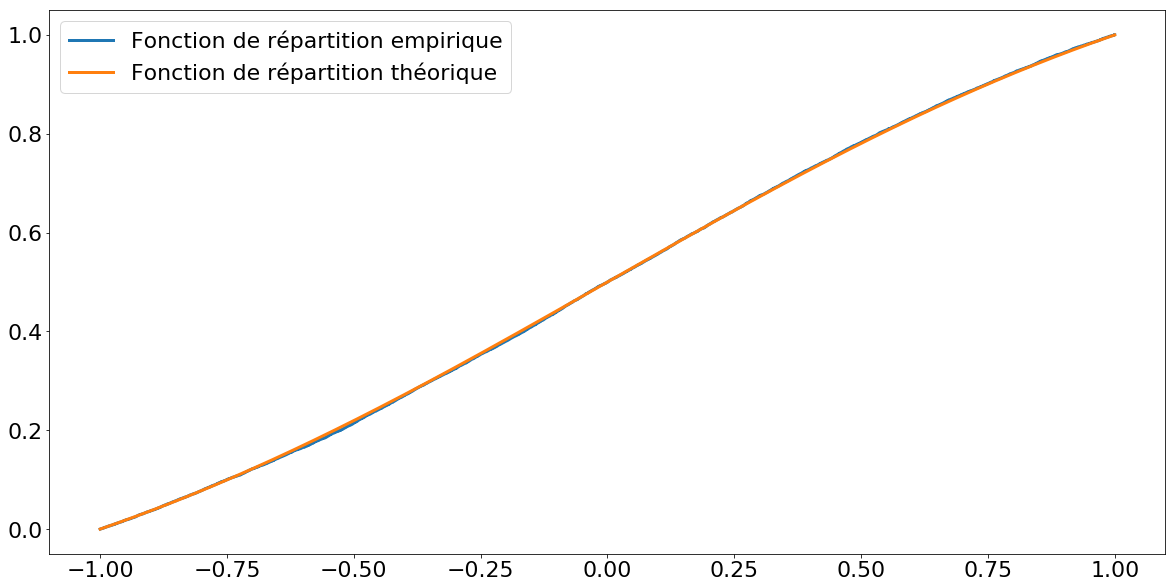

In [148]:
taille_echantillon = 10**5
K = 2
x = np.random.uniform(-1,1,taille_echantillon)
u = np.random.uniform(0,K,taille_echantillon)
echantillon = x[u <= stats.truncnorm.pdf(x, -1, 1)]
s, y = ecdf(echantillon)
s = s[1:-1]
y = y[1:-1]
plt.step(s, y, label="Fonction de répartition empirique")
plt.plot(s, stats.truncnorm.cdf(s, -1, 1), label= "Fonction de répartition théorique")
plt.legend()
print(len(echantillon))

In [149]:
a = len(echantillon)/taille_echantillon
print(a)

0.25054


<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.3.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.4.</b> A l'aide de la méthode du rejet, écrivez un code qui permet de générer une variable aléatoire de densité $\displaystyle f(x) \propto \lvert x \rvert \exp(\lvert x \rvert^\pi) {\bf 1}(\lvert x \rvert < 1)$. Le code suivant vous permet de calculer la constante de normalisation.</p>

In [ ]:
def f_unnor(x):
    return np.abs(x)*np.exp(np.abs(x)**np.pi)
from scipy.integrate import quad
constante = quad(f_unnor, -1, 1)[0]

In [ ]:
# TO DO

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.4.</b> </div>